# CA4 Report
Mohammad Hosein Moti Birjandi - 810194472

In [0]:
!pip install torchvision

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

# Loading CIFAR10
In this section we will use torchvision datasets to load CIFAR10 dataset .

## Loading Raw Data

In [0]:
transform = transforms.ToTensor()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Loading Normalized Data
As mentioned in pytorch documents the output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]. Tensor is a multidimensional array like numpy array used in **PyTorch**.

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

norm_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
norm_trainloader = torch.utils.data.DataLoader(norm_trainset, batch_size=32,
                                          shuffle=True, num_workers=4)

norm_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
norm_testloader = torch.utils.data.DataLoader(norm_testset, batch_size=32,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Visualizing CIFAR10 Samples
In this section we will visualize some CIFAR10 samples so we can verify data loaded correctly.

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

list of first batch images labels:
 bird  frog plane   car  frog  bird horse horse  ship  deer plane horse   cat truck   car  bird  ship  bird  bird   dog   cat horse  bird   cat horse truck  deer horse   car  bird  ship  ship


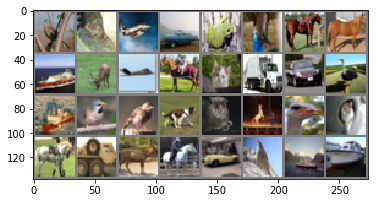

In [0]:
# get images of first batch for visualization
dataiter = iter(norm_trainloader)
images, labels = dataiter.next()
img = torchvision.utils.make_grid(images)
#as we applied a transform to images and normalized them, we need to unnormalize the images.
img = img/2+0.5
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
print('list of first batch images labels:')
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

# Define Convolutional Neural Network


## 1.

### Defining Convolutional Neural Network
In this section we will define a CNN. with 3 hidden layers.

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.conv2 = nn.Conv2d(12, 26, 3)
        self.fc3 = nn.Linear(26*6*6, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Initializing With Random Weights
First we will initiate convolutional layers weights using **uniform tensors**. The boundaries of this uniform tensor selected randomly.
Also we will initiate linear layer weights with tensor generated by **xavier_uniform** function.

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


Create loss function and optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training the network

In [0]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


end = time.time()
print('Finished Training')
print('Training duration is: ', end - start)

Finished Training
Training duration is:  128.35139155387878


Testing the network and calculate accuracy.

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 47 %


But if we use the random generator of pytorch accuracy will decrease significantly. See following section.

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
net.conv1.weight = nn.Parameter(torch.randn(12,3,3,3))
net.conv2.weight = nn.Parameter(torch.randn(26,12,3,3))
net.fc3.weight = nn.Parameter(torch.randn(10,936))
print('Init Finished')

Init Finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


Very very bad accuracy.

### Initializing All Weights to Zero
In this section we will initiate all weights and biases to zero.

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
nn.init.zeros_(net.conv1.bias)
nn.init.zeros_(net.conv1.weight)
nn.init.zeros_(net.conv2.bias)
nn.init.zeros_(net.conv2.weight)
nn.init.zeros_(net.fc3.bias)
nn.init.zeros_(net.fc3.weight)
print('Init finished')

Init finished


Create loss function and optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training the network

In [0]:
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


Testing the network and calculate accuracy.

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


## 2.



### Defining 2 Layered CNN With 3*3 Filter
In this section we will define a CNN. with 3 hidden layers.

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.fc3 = nn.Linear(12*15*15, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


Create loss function and optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training the network

In [0]:
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


Testing the network and calculate accuracy.

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


Now we will increase size of the filter.


### Defining 2 Layered CNN With 5*5 Filter
In this section we will define a CNN. with 3 hidden layers.


In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.fc3 = nn.Linear(12*14*14, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


Create loss function and optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training the network

In [0]:
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


Testing the network and calculate accuracy.

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


And now we will increase it again to figure out impact of increasing the filter size on accuracy.

### Defining 2 Layered CNN With 7*7 Filter
In this section we will define a CNN. with 3 hidden layers.


In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 7)
        self.fc3 = nn.Linear(12*13*13, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


Create loss function and optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training the network

In [0]:
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


Testing the network and calculate accuracy.

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %


As you can see when we increase size of filter, accuracy decreases. So the **best size is 3** for square filter.

## 3.

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.conv2 = nn.Conv2d(12, 26, 3)
        self.fc3 = nn.Linear(26*6*6, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


Create loss function and optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training the network

In [0]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start)

Finished Training
Tarining Duration:  139.04268622398376


Testing the network and calculate accuracy.

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


As you can see accuracy of this network which has trained with normalized data increased by 2% .
So normalization makes training procedure more accurate.

We normalize the data without taking care about their labels because, we apply the normalization matrix to all dataset and there is no difference between them.

## 4.

### High Learning Rate

In [124]:
norm_trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
norm_testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
hlr_loss_vals = list()

In [126]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        hlr_loss_vals.append(loss.item())

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start)

Finished Training
Tarining Duration:  127.61763739585876


In [127]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 43 %


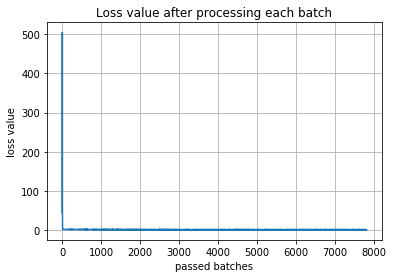

In [128]:
x = np.array([n for n in range(0, len(hlr_loss_vals))])
plt.plot(x, hlr_loss_vals)
plt.title(r'Loss value after processing each batch') 
plt.xlabel('passed batches') 
plt.ylabel('loss value') 
plt.grid() 
plt.show() 


In [129]:
for i in range(0,20):
  print(i, ' batches passed and loss value is: ', hlr_loss_vals[i])

0  batches passed and loss value is:  44.95771408081055
1  batches passed and loss value is:  504.4513244628906
2  batches passed and loss value is:  64.2362289428711
3  batches passed and loss value is:  46.018768310546875
4  batches passed and loss value is:  27.64629364013672
5  batches passed and loss value is:  12.37315559387207
6  batches passed and loss value is:  21.41192054748535
7  batches passed and loss value is:  3.465538263320923
8  batches passed and loss value is:  2.780107021331787
9  batches passed and loss value is:  2.3776187896728516
10  batches passed and loss value is:  2.2340216636657715
11  batches passed and loss value is:  2.4121756553649902
12  batches passed and loss value is:  2.385164499282837
13  batches passed and loss value is:  2.3215243816375732
14  batches passed and loss value is:  2.268362522125244
15  batches passed and loss value is:  2.3144397735595703
16  batches passed and loss value is:  2.2533299922943115
17  batches passed and loss value i

So if we ignore first fifteen loss values we will see rest of plot more accuratly.

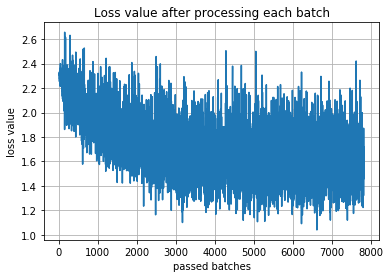

In [130]:
plt.plot(x[15:], hlr_loss_vals[15:])
plt.title(r'Loss value after processing each batch') 
plt.xlabel('passed batches') 
plt.ylabel('loss value') 
plt.grid() 
plt.show() 

### Normal Learning Rate

In [131]:
norm_trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
norm_testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
nlr_loss_vals = list()

In [133]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        nlr_loss_vals.append(loss.item())
        

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start)

Finished Training
Tarining Duration:  131.13981127738953


In [134]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


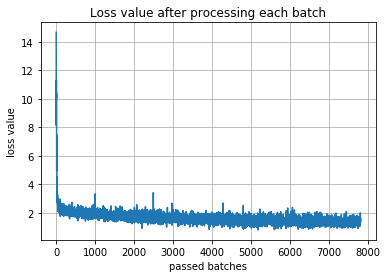

7815


In [135]:
x = np.array([n for n in range(0, len(nlr_loss_vals))])
plt.plot(x, nlr_loss_vals)
plt.title(r'Loss value after processing each batch') 
plt.xlabel('passed batches') 
plt.ylabel('loss value') 
plt.grid() 
plt.show() 
print(len(nlr_loss_vals))

In [136]:
for i in range(0,50):
  print(i, ' batches passed and loss value is: ', nlr_loss_vals[i])

0  batches passed and loss value is:  14.670442581176758
1  batches passed and loss value is:  13.655631065368652
2  batches passed and loss value is:  9.33906364440918
3  batches passed and loss value is:  8.15156364440918
4  batches passed and loss value is:  8.67447566986084
5  batches passed and loss value is:  11.317806243896484
6  batches passed and loss value is:  10.928202629089355
7  batches passed and loss value is:  9.981711387634277
8  batches passed and loss value is:  10.298108100891113
9  batches passed and loss value is:  10.432217597961426
10  batches passed and loss value is:  8.856528282165527
11  batches passed and loss value is:  6.636811256408691
12  batches passed and loss value is:  5.758289337158203
13  batches passed and loss value is:  4.958262920379639
14  batches passed and loss value is:  7.158292770385742
15  batches passed and loss value is:  6.791218280792236
16  batches passed and loss value is:  7.46943473815918
17  batches passed and loss value is:  

So if we ignore first fifty loss values we will see rest of plot more accuratly.

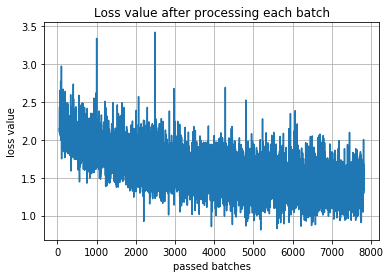

In [137]:
plt.plot(x[50:], nlr_loss_vals[50:])
plt.title(r'Loss value after processing each batch') 
plt.xlabel('passed batches') 
plt.ylabel('loss value') 
plt.grid() 
plt.show() 

### Slow Learning Rate

In [0]:
norm_trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
norm_testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
slr_loss_vals = list()

In [0]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        slr_loss_vals.append(loss.item())

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start)

Finished Training
Tarining Duration:  140.54821228981018


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 33 %


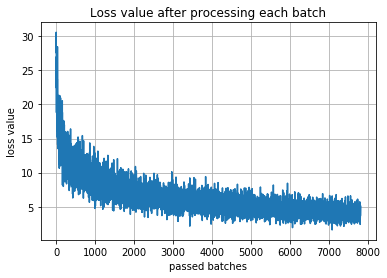

In [0]:
x = np.array([n for n in range(0, len(hlr_loss_vals))])
plt.plot(x, slr_loss_vals)
plt.title(r'Loss value after processing each batch') 
plt.xlabel('passed batches') 
plt.ylabel('loss value') 
plt.grid() 
plt.show() 


So if we ignore first fifty loss values we will see rest of plot more accuratly.

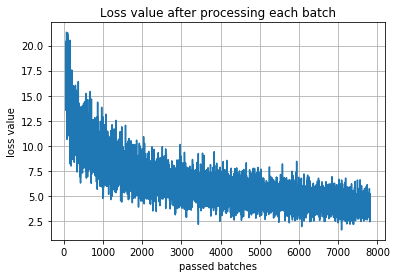

In [0]:
plt.plot(x[50:], slr_loss_vals[50:])
plt.title(r'Loss value after processing each batch') 
plt.xlabel('passed batches') 
plt.ylabel('loss value') 
plt.grid() 
plt.show() 

### Discussion
Learning rate is a hyper-parameter that controls how much we are adjusting the weights of our network with respect the loss gradient.

The usual formula of updating weights is:


```
new_weight = current_weights - learning_rate * gradient
```

So the lower the value, the slower we travel along the downward slope and it's more accurate, but it may take long time to converge. See following picture.
![converge to local minima](https://cdn-images-1.medium.com/max/1600/0*00BrbBeDrFOjocpK.)

The best way is by training the model initially with a very low learning rate and increasing it at each iteration.

Let's try it.

In [0]:
norm_trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
norm_testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
lr = np.linspace(0.001, 1, 9000)
ilr_loss_vals = list()

In [0]:
start = time.time()
for epoch in range(5):
    k = 0
    running_loss = 0.0
    for i, data in enumerate(norm_trainloader, 0):
        
        inputs, labels = data
        optimizer = optim.SGD(net.parameters(), lr=lr[k], momentum=0.9)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ilr_loss_vals.append(loss.item())
        k+=1

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start)

Finished Training
Tarining Duration:  358.9672122001648


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


As you can see the network is more accurate than the network which trained using normal value for learning rate.

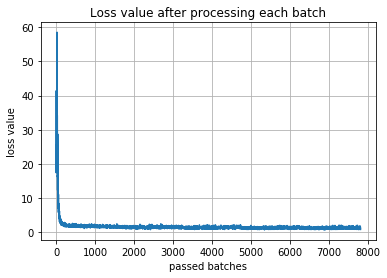

In [0]:
x = np.array([n for n in range(0, len(hlr_loss_vals))])
plt.plot(x, ilr_loss_vals)
plt.title(r'Loss value after processing each batch') 
plt.xlabel('passed batches') 
plt.ylabel('loss value') 
plt.grid() 
plt.show() 


So if we ignore first fifty loss values we will see rest of plot more accuratly.

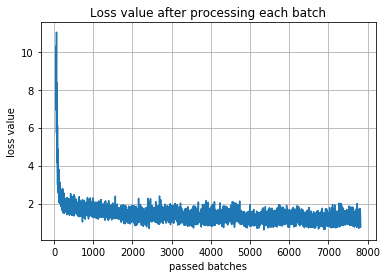

In [0]:
plt.plot(x[50:], ilr_loss_vals[50:])
plt.title(r'Loss value after processing each batch') 
plt.xlabel('passed batches') 
plt.ylabel('loss value') 
plt.grid() 
plt.show() 

## 5.


### Set Batch Size to 64

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

norm_64_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
norm_64_trainloader = torch.utils.data.DataLoader(norm_trainset, batch_size=64,
                                          shuffle=True, num_workers=4)

norm_64_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
norm_64_testloader = torch.utils.data.DataLoader(norm_testset, batch_size=64,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
nlr_loss_vals = list()

In [0]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_64_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        nlr_loss_vals.append(loss.item())
        

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start, ' seconds')

Finished Training
Tarining Duration:  123.81409502029419  seconds


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_64_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


### Set Batch Size to 256

In [138]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

norm_256_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
norm_256_trainloader = torch.utils.data.DataLoader(norm_trainset, batch_size=256,
                                          shuffle=True, num_workers=4)

norm_256_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
norm_256_testloader = torch.utils.data.DataLoader(norm_testset, batch_size=256,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [139]:
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
nlr_loss_vals = list()

In [141]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_256_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        nlr_loss_vals.append(loss.item())
        

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start, ' seconds')

Finished Training
Tarining Duration:  122.2474570274353  seconds


In [142]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_256_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 44 %


When we increase the batch size accuracy reduced.

So now let's check what will be happened if we increase learning rate.

In [143]:
norm_256_trainloader = torch.utils.data.DataLoader(norm_trainset, batch_size=256, shuffle=True, num_workers=4)
norm_256_testloader = torch.utils.data.DataLoader(norm_testset, batch_size=256, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
nlr_loss_vals = list()

In [145]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_256_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        nlr_loss_vals.append(loss.item())
        

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start, ' seconds')

Finished Training
Tarining Duration:  121.27707171440125  seconds


In [146]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_256_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 37 %


And let's check what happenes if we decrease learning rate value.

In [171]:
norm_256_trainloader = torch.utils.data.DataLoader(norm_trainset, batch_size=256, shuffle=True, num_workers=4)
norm_256_testloader = torch.utils.data.DataLoader(norm_testset, batch_size=256, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
nlr_loss_vals = list()

In [173]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_256_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        nlr_loss_vals.append(loss.item())
        

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start, ' seconds')

Finished Training
Tarining Duration:  355.7347331047058  seconds


In [174]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_256_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 32 %


### Discussion
When we increase the batch size we must reduce the learning rate. This must happen to keep variance in the gradient expectation constant. But if we reduce learning rate too much, the accuracy will decrease. 
There is a trade off between size of batched data and learning rate.

## 6.

### Use "tanh" As An Activation Function

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.conv2 = nn.Conv2d(12, 26, 3)
        self.fc3 = nn.Linear(26*6*6, 10)

    def forward(self, x):
        x = F.max_pool2d(F.tanh(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [152]:
norm_trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
norm_testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [154]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_256_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()        

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start, ' seconds')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Finished Training
Tarining Duration:  136.78870916366577  seconds


In [155]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_256_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy of the network on the 10000 test images: 38 %


### Use "relu" As An Activation Function

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.conv2 = nn.Conv2d(12, 26, 3)
        self.fc3 = nn.Linear(26*6*6, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [176]:
norm_trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
norm_testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [178]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()        

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start, ' seconds')

Finished Training
Tarining Duration:  132.4133665561676  seconds


In [179]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


### Use "leaky relu" As An Activation Function

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.conv2 = nn.Conv2d(12, 26, 3)
        self.fc3 = nn.Linear(26*6*6, 10)

    def forward(self, x):
        x = F.max_pool2d(F.leaky_relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.leaky_relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [181]:
norm_trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
norm_testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [183]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()        

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start, ' seconds')

Finished Training
Tarining Duration:  147.7651617527008  seconds


In [184]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 47 %


### Use "softplus" As An Activation Function

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.conv2 = nn.Conv2d(12, 26, 3)
        self.fc3 = nn.Linear(26*6*6, 10)

    def forward(self, x):
        x = F.max_pool2d(F.softplus(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.softplus(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [167]:
norm_trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
norm_testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [169]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_256_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()        

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start, ' seconds')

Finished Training
Tarining Duration:  351.65156412124634  seconds


In [170]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_256_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 40 %


### Discussion
As you can see in [relu section](https://colab.research.google.com/drive/1aa6h7i9Z5FocPQLOJ6rpUpVOIpuOKDX_#scrollTo=0tIJ7IeTNu1o&line=5&uniqifier=1)
we got most accurate network using **Relu** function.

Relu makes the network more lighter than other activation functions because for each negetive value, neuron do not fire so we will have sparce activation. As it return the value for x greater than zero, impact of those neurons are more than the others in output of the network.

## 7.

### Using Momentum

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.conv2 = nn.Conv2d(12, 26, 3)
        self.fc3 = nn.Linear(26*6*6, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_256_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()        

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start, ' seconds')

Finished Training
Tarining Duration:  122.43198752403259  seconds


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_256_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 45 %


### Without Momentum

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.conv2 = nn.Conv2d(12, 26, 3)
        self.fc3 = nn.Linear(26*6*6, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
net = Net()
nn.init.uniform_(net.conv1.weight,-2.0, 2.0)
nn.init.uniform_(net.conv2.weight, -1.0,1.0)
nn.init.xavier_uniform_(net.fc3.weight, gain=nn.init.calculate_gain('relu'))
print('Init finished')

Init finished


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [0]:
start = time.time()
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(norm_256_trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()        

end = time.time()
print('Finished Training')
print('Tarining Duration: ', end - start, ' seconds')

Finished Training
Tarining Duration:  123.98249506950378  seconds


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in norm_256_testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 32 %


### Discussion
As you can see the network which uses SGD with momentum perform more accurate than the network which uses classic SGD.

The reason is with SGD we don’t compute the exact derivate of our loss function. Instead, we’re estimating it on a small batch. Which means we’re not always going in the optimal direction, because our derivatives are **noisy**. So, exponentially weighed averages can provide us a better estimate which is closer to the actual derivate than our noisy calculations.